ported from Chengyu Fang's matlab code

In [38]:
## general imports
from numpy import *
from numpy.fft import fft,ifft,fft2,ifft2,fftshift,ifftshift
from scipy.special import j0, j1
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [39]:
mat = loadmat('radius_map_for_bottle_beam_Si_on_Sapphire_NA_0p8_H_500nm_P_360nm.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}

In [84]:
## physics and system params. all units in m
lmbda = 0.77e-6
k = 2*pi/lmbda

x_design = mat['x_design'][0]

## grid params
N = len(x_design)
dx = 360e-9
xspan = N*dx
x_list = x_design
y_list = -x_list
X, Y = meshgrid(x_list, y_list)
R = sqrt(X**2 + Y**2)
amplitude = 1 # for input Gaussian beam
w0 = 4.7e-4 # waist of LG beams

E_g = amplitude*exp(-(R/w0)**2)
E_array = E_g*exp(1j*mat['Phase_design'])

In [85]:
## compute output field with Fourier propagation

# define k space grid and field
dfx = 1/(xspan)
fx_list = arange(-N//2,N//2,1)*dfx
kx_list = 2*pi*fx_list
ky_list = -kx_list
KX, KY = meshgrid(kx_list, ky_list)
KZ_real = real(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ_imag = imag(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ = KZ_real + 1j*abs(KZ_imag)
E_array_kspace = fftshift(fft2(E_array))

# propagate
z_distance = 498e-6
phase = f*KZ_real % 2*pi
E_array_after_prop_kspace = E_array_kspace*exp(1j*z_distance*KZ)

# transform back to real space
E_array_after_prop = ifft2(E_array_after_prop_kspace)
field1 = E_array_after_prop
I1_FD = real(conjugate(field1)*field1)
I1_FD /= amax(I1_FD)

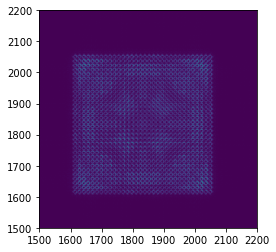

In [86]:
plt.xlim(1500,2200)
plt.ylim(1500,2200)
plt.imshow(I1_FD)

In [83]:
# verify the validity condition for this method
assert z > 2*N*dx**2*sqrt(1-(lmbda/(2*dx))**2)/lmbda, z/(2*N*dx**2*sqrt(1-(lmbda/(2*dx))**2)/lmbda) 

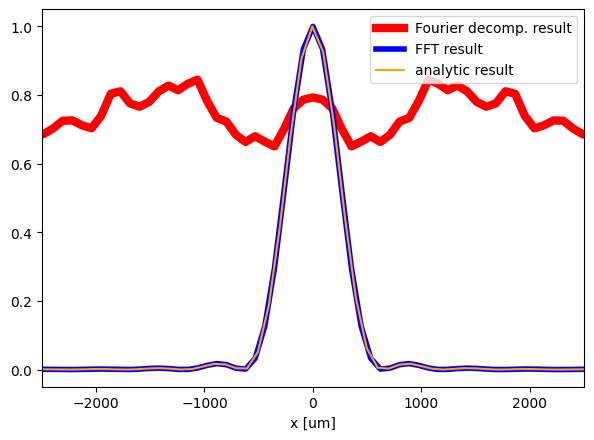

In [12]:
## plot a slice of the field in the Fourier plane

plt.close()
fig,ax = plt.subplots(figsize=(7,5))
fig.dpi=100

x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])

start = 400
stop = len(x1pts) - start

# plot the analytic result, up to constant scaling factor
I1_func = lambda x: (j1(a*x*k/f)/x)**2
x1_pts = linspace(x1pts[start],x1pts[stop],200) # essentially the same as x1pts but omits x=0
I1_analytic = I1_func(x1_pts)
I1_analytic /= max(I1_analytic)

# plot the fourier decomp result
ax.plot(x1pts[start:stop], real(I1x_FD)[start:stop], label='Fourier decomp. result',color='red',linewidth=6)

# plot the fft result
ax.plot(x1pts[start:stop], real(I1x)[start:stop], label='FFT result',color='blue',linewidth=4)

ax.plot(x1_pts, I1_analytic, label='analytic result', color='orange')
# ax.set_title('Circular apperture diffraction intensity')

ax.set_xlabel(r'x [um]')
ax.set_xlim(-2500,2500)

ax.legend(loc='upper right')

## Chengyu's example